## Import Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [44]:
stock_ntr = pd.read_csv('../../../Dataset/NTR.csv')
stock_ntr

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [45]:
# Convert the 'Date' column to datetime format
stock_ntr['Date'] = pd.to_datetime(stock_ntr['Date'])

# Set the 'Date' column as the index value
stock_ntr = stock_ntr.set_index(pd.DatetimeIndex(stock_ntr['Date'].values))

# Create new datafram with Date and Close
df_ntr = pd.DataFrame(stock_ntr, columns=['Close'])

### Data normalization

In [46]:
scaler = MinMaxScaler(feature_range=(0,1))
df_ntr = scaler.fit_transform(np.array(df_ntr).reshape(-1,1))

### Data splitting

In [47]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(df_ntr) * 0.6)
val_size = int(len(df_ntr) * 0.2)
test_size = len(df_ntr) - train_size - val_size

In [48]:
# Get Data 
train_data = df_ntr[:train_size]
val_data = df_ntr[train_size:train_size+val_size]
test_data = df_ntr[train_size+val_size:]

In [49]:
# Create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [50]:
# Reshape into X=t,t+1,t+2..t+100 and Y=t+100
time_step = 100

# Get lost data for test
train_last_windowsize = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)

# Get lost data for val
val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data_extended, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [51]:
# Tạo input cho dữ liệu đầu vào LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

## Model training and testing

In [52]:
# Define model
    # Pack the sequence of the inner layers
model = Sequential()
    # LSTM with 64 units with reture_sequences = true => preidct along to the series
model.add(LSTM(64, return_sequences=True, input_shape = (time_step, 1)))
    # LSTM with 64 units with reture_sequences = false => get the last predict
model.add(LSTM(64, return_sequences=False, input_shape = (time_step, 1)))
    # Dropout: Avoid remembering too much information => disable part of the previous data
model.add(Dropout(0.2))
    # 1 Dense layer (dense): 1 unit provides predictive value, using activiation function: relu
model.add(Dense(1,activation='relu'))
    # Compile model with loss function: MST, optimize: adam 
model.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
# Using earlystopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [54]:
# Training LSTM model
model.fit(X_train, y_train, validation_data=(X_val, yval), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100
9/9 [==============================] - 12s 449ms/step - loss: 0.0211 - val_loss: 0.0138
Epoch 2/100
9/9 [==============================] - 4s 521ms/step - loss: 0.0047 - val_loss: 0.0371
Epoch 3/100
9/9 [==============================] - 2s 260ms/step - loss: 0.0030 - val_loss: 0.0086
Epoch 4/100
9/9 [==============================] - 2s 280ms/step - loss: 0.0023 - val_loss: 0.0211
Epoch 5/100
9/9 [==============================] - 3s 304ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 6/100
9/9 [==============================] - 3s 294ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 7/100
9/9 [==============================] - 3s 373ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 8/100
9/9 [==============================] - 3s 298ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 9/100
9/9 [==============================] - 2s 248ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 10/100
9/9 [==============================] - 3s 394ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 11

### Testing process

In [55]:
# Predict
    # Test
y_pred = model.predict(X_test)
    # Val
y_pred_val = model.predict(X_val)

7/7 [==============================] - 0s 61ms/step


### Evaluate model

In [56]:
# Evaluate the accuracy of validate
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
val_mse = mean_squared_error(y_pred_val, yval)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, yval)

print(f"MAPE on Validate dataset: ", val_mape)
print(f"RMSE on Validate dataset: ", val_rmse)
print(f"MSLE on Validate dataset: ", val_msle)

MAPE on Validate dataset:  0.04491361520715097
RMSE on Validate dataset:  0.041843886143199546
MSLE on Validate dataset:  0.0005772304036012238


In [57]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.042614714262108715
RMSE on Test dataset:  0.03389468690155685
MSLE on Test dataset:  0.0004460202310706228


## Predicting the next 30 days

### Preparing the prediction data

In [58]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [59]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.38164693117141724], [0.38968631625175476], [0.39524587988853455], [0.3989846408367157], [0.4013420045375824], [0.40261316299438477], [0.4030056893825531], [0.40267956256866455], [0.4017709791660309], [0.4004048705101013], [0.39869898557662964], [0.3967643678188324], [0.39470434188842773], [0.39261168241500854], [0.3905661106109619], [0.3886336088180542], [0.38686561584472656], [0.38529857993125916], [0.3839554488658905], [0.38284629583358765], [0.38197025656700134], [0.3813173174858093], [0.3808700442314148], [0.38060542941093445], [0.3804970383644104], [0.3805161714553833], [0.38063374161720276], [0.3808211088180542], [0.38105133175849915], [0.3813002109527588]]


### Preparing the forecast date index

In [60]:
# Get the last date from the current index
last_date = stock_ntr.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [61]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [62]:
# Convert to normal values
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

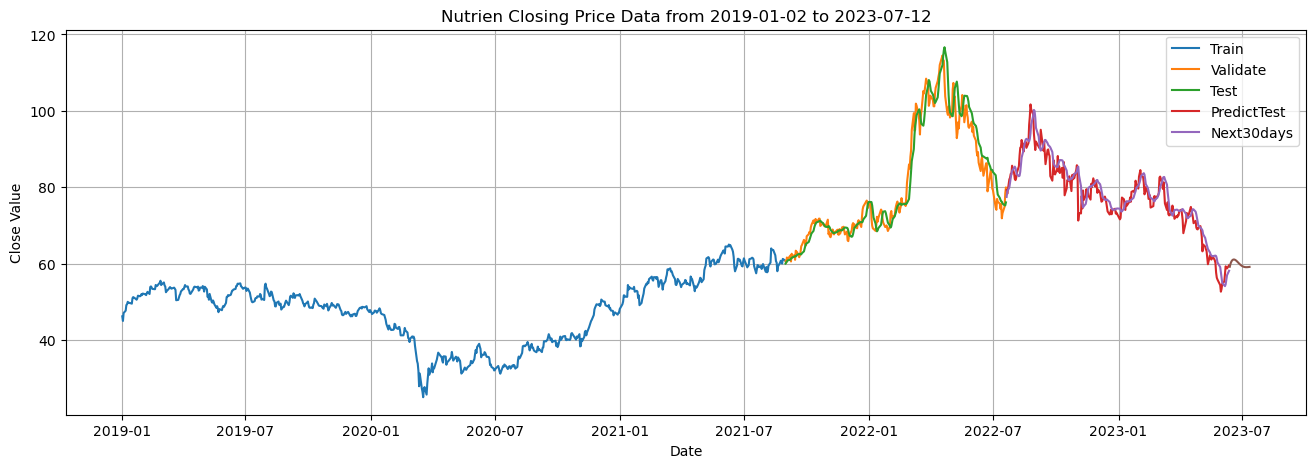

In [63]:
plt.figure(figsize=(16,5))

plt.plot(stock_ntr.index[:train_size], train_data)

plt.plot(stock_ntr.index[train_size:train_size + val_size],val_data)

plt.plot(stock_ntr.index[train_size:train_size + val_size],y_pred_val)

plt.plot(stock_ntr.index[train_size + val_size: ], test_data)

plt.plot(stock_ntr.index[train_size + val_size: ],(y_pred))

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Nutrien Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/LSTM_622_NTR.png')
plt.show()